In [282]:
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use("myplot")
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
from scipy.optimize import lsq_linear

cmap = plt.get_cmap("jet")

In [283]:
"""
Raman spectrum of alpha-ET during image scan
・single spectrum (60 sec per 1 point)
・Laser intensity = 60 uW 
"""

'\nRaman spectrum of alpha-ET during image scan\n・single spectrum (60 sec per 1 point)\n・Laser intensity = 60 uW \n'

In [284]:
### Obtain ref. spectrum

temp_list = [150,145,140,135,130,125,120]
date_list = [250901,250903,250903,250903,250908,250910,250910]

data_ref = {}

for temp, date in zip(temp_list,date_list):
    filename = f"imaging_0p5uW_1/{date}_{temp}K_0p5uW_step5/{temp}K_0p5uW_300sec.txt"
    if os.path.exists(filename):
        key = (temp)
        data_ref[key] = np.loadtxt(filename, delimiter="\t")


In [285]:
def Raman_shift(x):
    return (1/532 - 1/x)*1e7

def remove_cosmic(y, window=5, poly=3, k=7):
    y_smooth = savgol_filter(y, window_length=window, polyorder=poly)
    r = y - y_smooth
    
    ### Median Absolute Deviation ###
    mad = np.median(np.abs(r - np.median(r)))
    sigma = 1.4826 * mad
    cosmic = np.abs(r) > k * sigma
    ###

    y_clean = y.copy()
    y_clean[cosmic] = np.nan
    
    return y_clean


In [286]:
def lorentz(x, A, x0, gamma):
    return A * (gamma**2) / ((x - x0)**2 + gamma**2)

def model_nlorentz_linbg(x, p, npeak):
    """
    return the lorentzian fitting result  
    npeak: number of peak
    p: set of parameters of Lorentzian 
    p = [A_1,x0_1,g_1,A_2,x0_2,g_2, ... ,c0,c1]
    """

    y = np.zeros_like(x, dtype=float)

    for i in range(npeak):
        A, x0, g = p[3*i:3*i+3]
        y += lorentz(x, A, x0, g)
    
    c0, c1 = p[3*npeak:3*npeak+2]
    
    return y + (c0 + c1*x)

def fit_nlorentz_linbg(x, y, x0_list, dx=5.0, g_init=5.0, gmin=0.5, gmax=50.0):
    """
    Fitting part

    x0_list: location of the each peak
    dx: the searching window of the peak location
    g_init: initial parameter of gamma
    g_min:
    g_max:
    """
    npeak = len(x0_list)

    # initial value
    c0 = np.nanmedian(y)
    A0 = np.nanmax(y) - c0
    p0 = []
    for x0 in x0_list:
        p0 += [0.7*A0, x0, g_init]
    p0 += [c0, 0.0]
    p0 = np.array(p0, float)

    # boundary conditions of parameters
    lb, ub = [], []
    for x0 in x0_list:
        lb += [0.0, x0-dx, gmin]
        ub += [np.inf, x0+dx, gmax]
    lb += [-np.inf, -np.inf]
    ub += [ np.inf,  np.inf]

    def resid(p):
        # residual error
        return model_nlorentz_linbg(x, p, npeak) - y

    # Fitting
    res = least_squares(resid, p0, bounds=(lb, ub), loss="soft_l1")

    return res.x # set of parameters


In [287]:
### Determine the ref. temperature
HT_temp = 150
LT_temp = 120

=== 150 K===
Peak1: x0=1468.779, FWHM=7.743, height=60.459
Peak2: x0=1484.803, FWHM=16.600, height=125.524
BG: c0=548.143, c1=-0.0285263
=== 120 K===
Peak1: x0=1459.883, FWHM=9.074, height=70.078
Peak2: x0=1472.293, FWHM=6.932, height=197.717
Peak3: x0=1480.816, FWHM=5.661, height=49.858
Peak4: x0=1530.848, FWHM=8.780, height=36.300
BG: c0=568.788, c1=-0.0395028


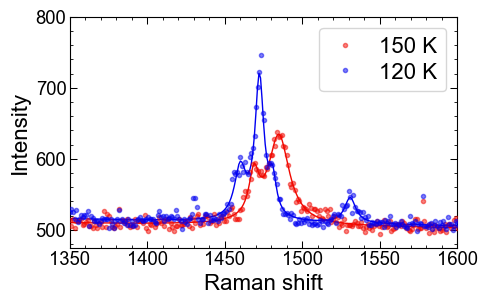

In [288]:
# -----------------------------
# plot 
# -----------------------------
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")
# ax.set_title(f"Reference spectrum")

x_HT = Raman_shift(data_ref[HT_temp][:,0])
y_HT = remove_cosmic(data_ref[HT_temp][:,1])

x_LT = Raman_shift(data_ref[LT_temp][:,0])
y_LT = remove_cosmic(data_ref[LT_temp][:,1])

mask_HT = (x_HT >= 1350) & (x_HT <= 1600)
xm_HT = x_HT[mask_HT]
ym_HT = y_HT[mask_HT]

mask_LT = (x_LT >= 1350) & (x_LT <= 1600)
xm_LT = x_LT[mask_LT]
ym_LT = y_LT[mask_LT]

## plot raw data (after removing cosmic ray)
ax.plot(x_HT, y_HT, color=cmap(0.9), linestyle="", marker=".", alpha=0.5, label=f"{HT_temp} K",zorder=5)
ax.plot(x_LT, y_LT, color=cmap(0.1), linestyle="", marker=".", alpha=0.5, label=f"{LT_temp} K",zorder=5)

## raw data for fitting 
xm_HT_fit = xm_HT[np.isfinite(ym_HT)]
ym_HT_fit = ym_HT[np.isfinite(ym_HT)]

xm_LT_fit = xm_LT[np.isfinite(ym_LT)]
ym_LT_fit = ym_LT[np.isfinite(ym_LT)]

## initial peak locations
x0_HT_list = [1468, 1484]
x0_LT_list = [1460,1472,1480,1530]

## fitting 
pfit_HT = fit_nlorentz_linbg(xm_HT_fit, ym_HT_fit, x0_list=x0_HT_list)
pfit_LT = fit_nlorentz_linbg(xm_LT_fit, ym_LT_fit, x0_list=x0_LT_list)

## show fitting results
xf = np.arange(1350,1601,1)
yfit_HT = model_nlorentz_linbg(xf, pfit_HT, npeak=len(x0_HT_list))
ax.plot(xf, yfit_HT,  color=cmap(0.9), lw=1)

yfit_LT = model_nlorentz_linbg(xf, pfit_LT, npeak=len(x0_LT_list))
ax.plot(xf, yfit_LT,  color=cmap(0.1), lw=1)

ax.set_xlim(1350,1600)
ax.set_ylim(475,800)
ax.legend()

## Result of parameters
print(f"=== {HT_temp} K===")
for i in range(len(x0_HT_list)):
    A, x0, g = pfit_HT[3*i:3*i+3]
    print(f"Peak{i+1}: x0={x0:.3f}, FWHM={2*g:.3f}, height={A:.3f}")
c0, c1 = pfit_HT[3*len(x0_HT_list):3*len(x0_HT_list)+2]
print(f"BG: c0={c0:.3f}, c1={c1:.6g}")

print(f"=== {LT_temp} K===")
for i in range(len(x0_LT_list)):
    A, x0, g = pfit_LT[3*i:3*i+3]
    print(f"Peak{i+1}: x0={x0:.3f}, FWHM={2*g:.3f}, height={A:.3f}")
c0, c1 = pfit_LT[3*len(x0_LT_list):3*len(x0_LT_list)+2]
print(f"BG: c0={c0:.3f}, c1={c1:.6g}")



(1350.0, 1600.0)

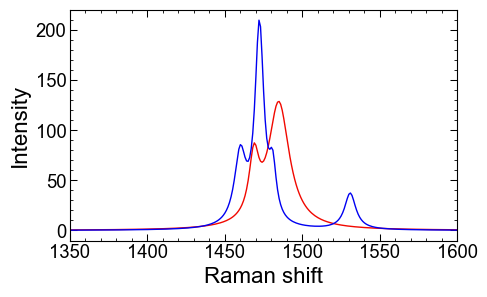

In [289]:
# -----------------------------
# plot 
# -----------------------------
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")
# ax.set_title(f"Reference spectrum (subtract BG)")

## show fitting results
pfit_HT_BG = np.copy(pfit_HT)
pfit_HT_BG[-1], pfit_HT_BG[-2] = 0, 0
yfit_HT = model_nlorentz_linbg(xf, pfit_HT_BG, npeak=len(x0_HT_list))
ax.plot(xf, yfit_HT,  color=cmap(0.9), lw=1, label=f"{HT_temp} K (Fit)")

pfit_LT_BG = np.copy(pfit_LT)
pfit_LT_BG[-1], pfit_LT_BG[-2] = 0, 0
yfit_LT = model_nlorentz_linbg(xf, pfit_LT_BG, npeak=len(x0_LT_list))
ax.plot(xf, yfit_LT,  color=cmap(0.1), lw=1, label=f"{LT_temp} K (Fit)")

ax.set_xlim(1350,1600)
# ax.set_ylim(475,800)
# ax.legend()

In [290]:
### import image scan data ### 

temp_list_2 = [138,136,134,132,130,128,126]
date_list_2 = [250930,251002,251007,251009,251014,251016,251018]

data = {}

###
# temp_img = 120
# date_img = date_list[np.where(np.array(temp_list) == temp_img)[0][0]]

temp_img = 126
date_img = date_list_2[np.where(np.array(temp_list_2) == temp_img)[0][0]]

wdir1 = "imaging_0p5uW_1/"
wdir2 = "imaging_0p5uW_2/"

for ii in range(1,52,1):
    # filename = wdir1 + f"{date_img}_{temp_img}K_0p5uW_step5/data/{ii:02d} Export File.txt"

    if temp_img == 126: # 01 Line_306_Spec.Data 1
        filename = wdir2 + f"{date_img}_{temp_img}K_0p5uW_aroundTc/data/{ii:02d} Line_{ii+305:02d}_Spec.Data 1.txt"
    else:
        filename = wdir2 + f"{date_img}_{temp_img}K_0p5uW_aroundTc/data/{ii:02d} Export File.txt"

    if os.path.exists(filename):
        key = (ii)
        data[key] = np.loadtxt(filename, delimiter="\t")


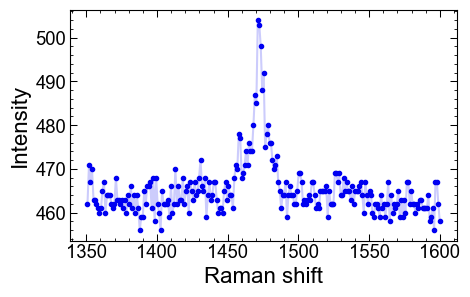

In [291]:
# -----------------------------
# plot at (line,idx)
# 1 < line < 51
# 1 < idx < 50 
# -----------------------------
line = 25
idx = 25

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")
# ax.set_title(f"#{line}-{idx}")

x = Raman_shift(data[line][:,0])
y = data[line][:,idx]
y_clean = remove_cosmic(y)

mask = (x >= 1350) & (x <= 1600)
xm = x[mask]
ym_raw = y[mask]
ym = y_clean[mask]

ax.plot(xm, ym_raw, color=cmap(0.1), alpha=0.2)
ax.plot(xm, ym, color=cmap(0.1), linestyle="", marker=".")

# ax.set_ylim(450,525)


In [292]:
def estimate_volume_fraction(xm, ym, yref_HT, yref_LT):
    """
    xm, ym : raw data
    yref_** : ref. spectrum (after BG subtracting)
    use_nnls : True if c0,c1>=0 
    """
    # interpolate ref. spectrum
    Ih = np.interp(xm, xf, yref_HT)
    Il = np.interp(xm, xf, yref_LT)

    # removing np. NaN
    ok = np.isfinite(xm) & np.isfinite(ym) & np.isfinite(Ih) & np.isfinite(Il)
    x = xm[ok]
    y = ym[ok]
    Ih = Ih[ok]
    Il = Il[ok]

    # y = c0*Ih + c1*Il + b0 + b1*x
    X = np.column_stack([Ih, Il, np.ones_like(x), x])

    # boundary conditions: c0,c1 >= 0 ; b0,b1 free
    lb = np.array([0.0, 0.0, -np.inf, -np.inf], dtype=float)
    ub = np.array([np.inf, np.inf,  np.inf,  np.inf], dtype=float)

    # solve constrained linear least squares
    res = lsq_linear(X, y, bounds=(lb, ub), method="trf", lsmr_tol="auto")
    beta = res.x
    c0, c1, b0, b1 = beta

    # calculate volume fraction of LT phase
    A = c0 + c1
    f = np.nan if A == 0 else (c1 / A)

    # fitted curve
    y_fit = X @ beta
    residual = y - y_fit

    return {
        "f": f, "A": A,
        "c0": c0, "c1": c1, "b0": b0, "b1": b1,
        "x": x, "y": y, "y_fit": y_fit, "Ih": Ih, "Il": Il, "residual" : residual
    }

=== fitting result at (25,25) ===
LT volume fraction = 1.0000
A (overall scale)  = 0.1709


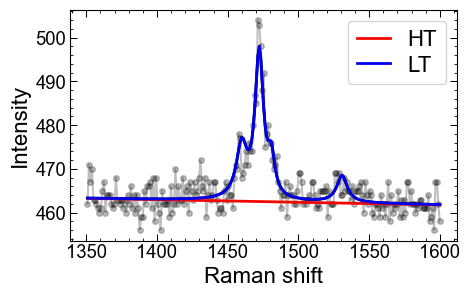

In [293]:
# -----------------------------
# Fitting at (line,idx)
# 1 < line < 51
# 1 < idx < 50 
# -----------------------------
line = 25
idx = 25

x = Raman_shift(data[line][:,0])
y = remove_cosmic(data[line][:,idx])

mask = (x >= 1350) & (x <= 1600)
xm = x[mask]
ym = y[mask]

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")
# ax.set_title(f"#{line}-{idx}")

# fitting result
res = estimate_volume_fraction(xm,ym,yfit_HT,yfit_LT)
ax.plot(res["x"], res["y"], color="black", alpha = 0.25, linestyle="-", marker="o",ms=4)
ax.plot(res["x"], res["y_fit"], color = "black",lw=2)

ax.plot(res["x"], res["c0"]*res["Ih"] + res["b0"] + res["b1"]*res["x"],lw=2,ls="-",color=cmap(0.9),label="HT")
ax.plot(res["x"], res["c1"]*res["Il"] + res["b0"] + res["b1"]*res["x"],lw=2,ls="-",color=cmap(0.1), label="LT")
# ax.plot(res["x"], res["b0"] + res["b1"]*res["x"],lw=2,ls="--",color="gray")

# ax.set_ylim(450,525)
ax.legend()

print(f"=== fitting result at ({line},{idx}) ===")
print(f"LT volume fraction = {res['f']:.4f}")
print(f"A (overall scale)  = {res['A']:.4f}")

In [294]:
n_line = 51
n_idx = 50

f_img = np.zeros((n_line,n_idx))
A_img = np.zeros((n_line,n_idx))
res_img = np.zeros((n_line,n_idx))
std_img = np.zeros((n_line,n_idx))

for line in range(1, n_line+1):
    for idx in range(1,n_idx+1):
        x = Raman_shift(data[line][:,0])
        y = remove_cosmic(data[line][:,idx])

        mask = (x >= 1350) & (x <= 1600)
        xm = x[mask]
        ym = y[mask]

        res = estimate_volume_fraction(xm,ym,yfit_HT,yfit_LT)

        f_img[line-1, idx-1] = res['f']
        A_img[line-1, idx-1] = res['A']
        res_img[line-1, idx-1] = np.sqrt(np.nanmean(res["residual"]**2))

        std_img[line-1, idx-1] = np.nanvar(res["y"] - res["b0"] -res["b1"]*res["x"])

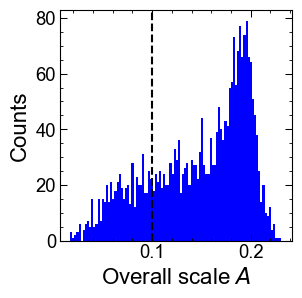

In [295]:
vals = A_img[np.isfinite(A_img)]

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.set_xlabel("Overall scale $A$")
ax.set_ylabel("Counts")
ax.hist(vals, bins=100,color="blue")
# ax.set_xlim(0,0.1)
ax.axvline(0.1, color="black", ls="--",)
plt.show()


=== fitting result at (26,11) ===
LT volume fraction = 1.0000
A (overall scale)  = 0.0948


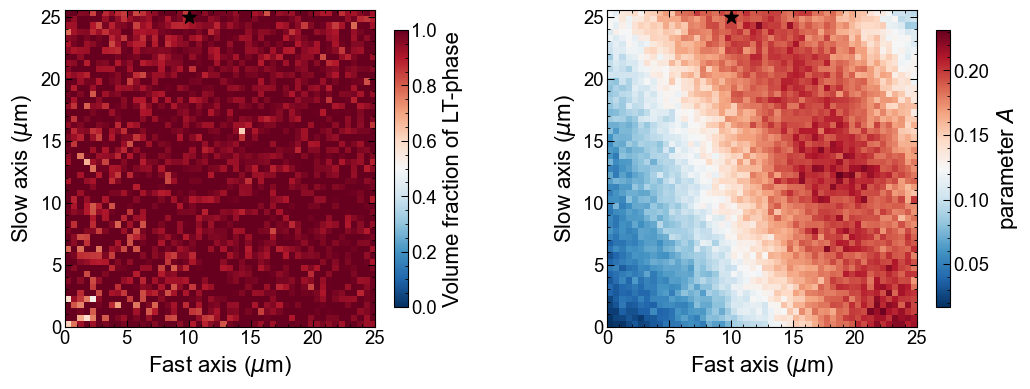

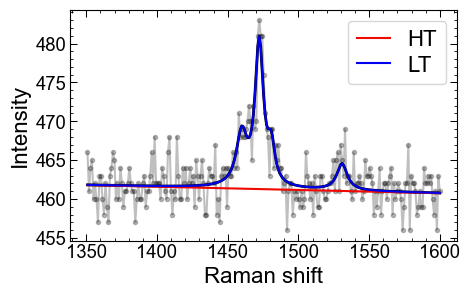

In [296]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.subplots_adjust(wspace=0.4)

ax = axes[0] 
ax.set_ylabel("Slow axis ($\mu$m)") # Line
ax.set_xlabel("Fast axis ($\mu$m)") # Index

pixel_size = 0.5  # µm
ny, nx = f_img.shape

im = ax.imshow(
    f_img,
    origin="lower",
    cmap='RdBu_r',
    vmin=0, vmax=1,
    extent = [0,nx*pixel_size,0,ny*pixel_size],
    aspect='equal'
)
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('Volume fraction of LT-phase')

ax = axes[1] 
ax.set_ylabel("Slow axis ($\mu$m)") # Line
ax.set_xlabel("Fast axis ($\mu$m)") # Index

im = ax.imshow(
    A_img,
    origin="lower",
    cmap='RdBu_r',
    extent = [0,nx*pixel_size,0,ny*pixel_size],
    aspect='equal'
)
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('parameter $A$')


### set ROI
xx, yy = 10,25

axes[0].scatter(xx, yy, marker="*", color="k", s=100)
axes[1].scatter(xx, yy, marker="*", color="k", s=100)

line = yy + 1   
idx  = xx + 1   

x = Raman_shift(data[line][:,0])
y = remove_cosmic(data[line][:,idx])

mask = (x >= 1350) & (x <= 1600)
xm = x[mask]
ym = y[mask]

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel("Raman shift")
ax.set_ylabel("Intensity")
# ax.set_title(f"#{line}-{idx}")

# fitting result
res = estimate_volume_fraction(xm,ym,yfit_HT,yfit_LT)
ax.plot(res["x"], res["y"], color="black", alpha = 0.25, linestyle="-", marker=".")
ax.plot(res["x"], res["y_fit"], color = "black", lw=2)

ax.plot(res["x"], res["c0"]*res["Ih"] + res["b0"] + res["b1"]*res["x"],lw=1.5,color=cmap(0.9),label="HT")
ax.plot(res["x"], res["c1"]*res["Il"] + res["b0"] + res["b1"]*res["x"],lw=1.5,color=cmap(0.1), label="LT")
# ax.plot(res["x"], res["b0"] + res["b1"]*res["x"],lw=1.5,ls="--",color="gray")

# ax.set_ylim(450,525)
ax.legend()

print(f"=== fitting result at ({line},{idx}) ===")
print(f"LT volume fraction = {res['f']:.4f}")
print(f"A (overall scale)  = {res['A']:.4f}")



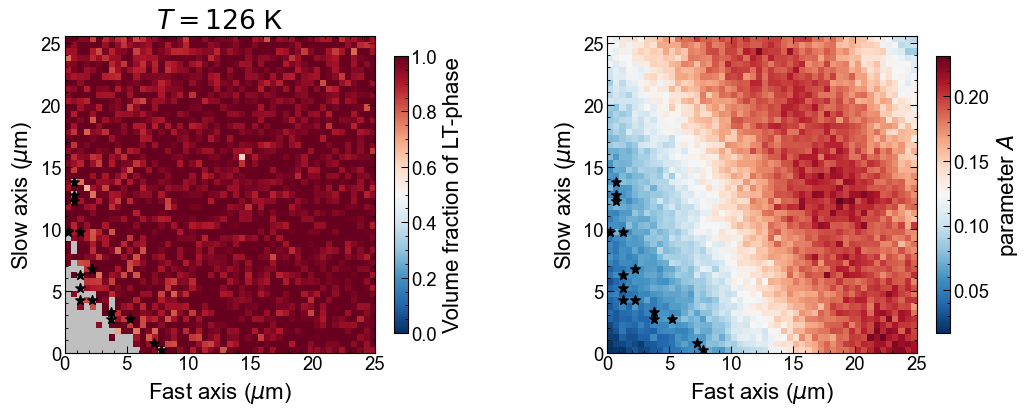

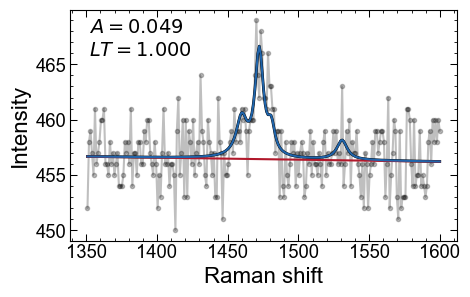

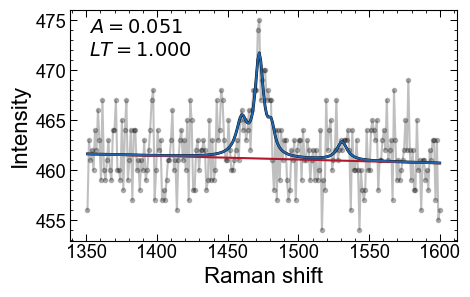

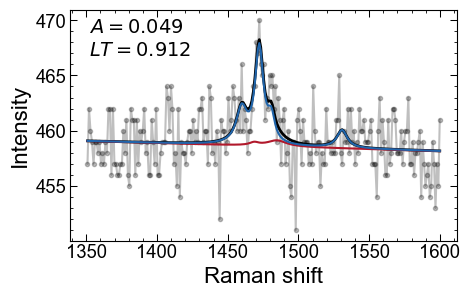

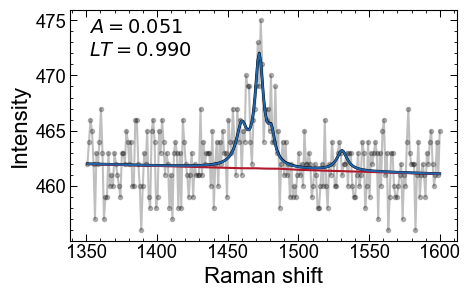

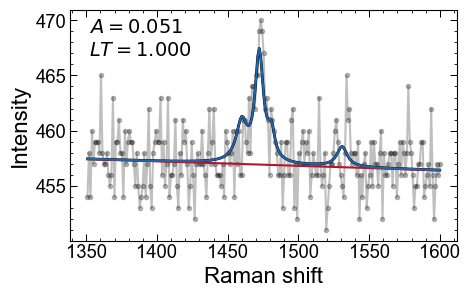

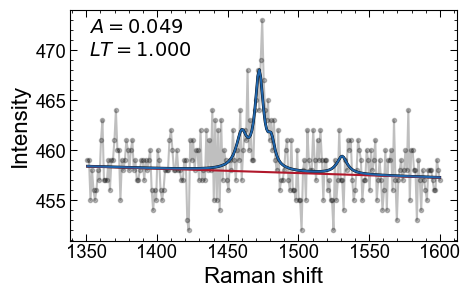

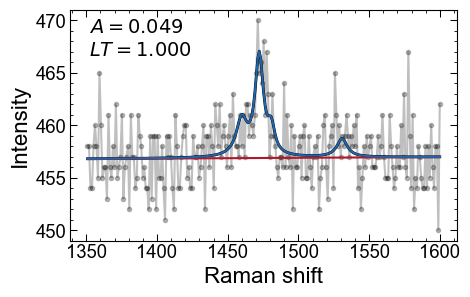

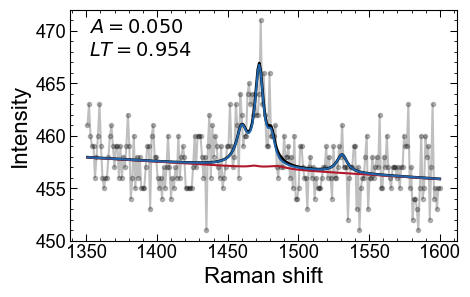

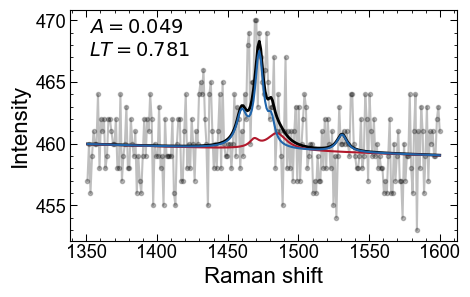

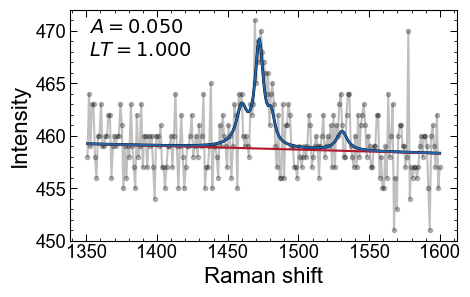

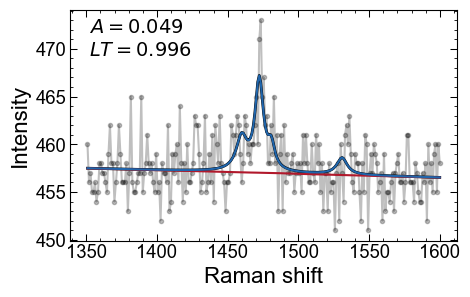

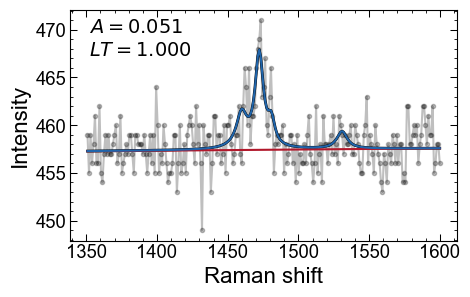

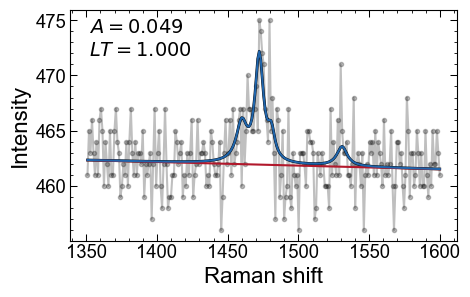

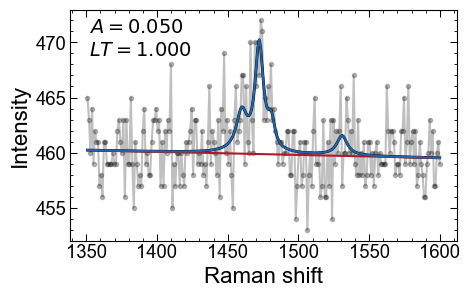

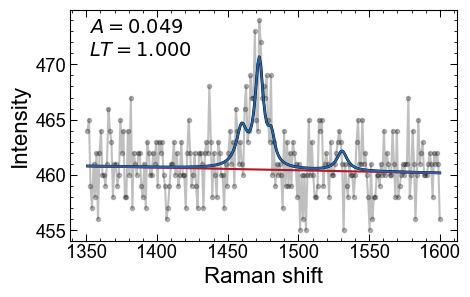

In [297]:
f_masked = f_img.copy()
A_masked = A_img.copy()

thr = 0.05
defocus_mask = A_img < thr

f_masked = np.ma.masked_where(defocus_mask, f_img)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
ax.set_ylabel("Slow axis ($\mu$m)") # Line
ax.set_xlabel("Fast axis ($\mu$m)") # Index
ax.set_title(f"$T={temp_img}$ K") # Index

cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad("gray",alpha=0.5)
ny, nx = f_masked.shape

im = ax.imshow(
    f_masked,
    origin="lower",
    cmap=cmap,
    vmin=0, vmax=1,
    extent = [0,nx*pixel_size,0,ny*pixel_size],
    aspect='equal'
)
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('Volume fraction of LT-phase')


ax = axes[1]
ax.set_ylabel("Slow axis ($\mu$m)") # Line
ax.set_xlabel("Fast axis ($\mu$m)") # Index

im = ax.imshow(
    A_img,
    origin="lower",
    cmap='RdBu_r',
    extent = [0,nx*pixel_size,0,ny*pixel_size],
    aspect='equal'
)
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('parameter $A$')


### set ROI
pos = np.where(np.abs(A_img - thr) < 0.001)

for yy, xx in zip(pos[0], pos[1]):
    x_um = (xx + 0.5) * pixel_size
    y_um = (yy + 0.5) * pixel_size
    axes[0].scatter(x_um, y_um, marker="*", color="black", s=50)
    axes[1].scatter(x_um, y_um, marker="*", color="black", s=50)
    
    line = yy + 1   
    idx  = xx + 1   

    x = Raman_shift(data[line][:,0])
    y = remove_cosmic(data[line][:,idx])

    mask = (x >= 1350) & (x <= 1600)
    xm = x[mask]
    ym = y[mask]

    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    ax.set_xlabel("Raman shift")
    ax.set_ylabel("Intensity")
    # ax.set_title(f"#{line}-{idx}")

    # fitting result
    res = estimate_volume_fraction(xm,ym,yfit_HT,yfit_LT)
    ax.text(0.05,0.9,f"$A = {res['A']:.3f}$",transform=ax.transAxes,fontsize = 14)
    ax.text(0.05,0.8,f"$LT = {res['f']:.3f}$",transform=ax.transAxes,fontsize = 14)
    ax.plot(res["x"], res["y"], color="black", alpha = 0.25, linestyle="-", marker=".")
    ax.plot(res["x"], res["y_fit"], color = "black", lw=2)

    ax.plot(res["x"], res["c0"]*res["Ih"] + res["b0"] + res["b1"]*res["x"],lw=1.5,color=cmap(0.9),label="HT")
    ax.plot(res["x"], res["c1"]*res["Il"] + res["b0"] + res["b1"]*res["x"],lw=1.5,color=cmap(0.1), label="LT")
    # ax.plot(res["x"], res["b0"] + res["b1"]*res["x"],lw=1.5,ls="--",color="gray")

    # ax.set_xlim(1350,1600)
    # ax.set_ylim(450,480)

    # ax.legend()

